In [ ]:
!nvidia-smi

Sat Feb  5 18:19:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# House Prices - Advanced Regression Techniques
Predict sales prices and practice feature engineering, RFs, and gradient boosting.  
kaggle: https://www.kaggle.com/c/house-prices-advanced-regression-techniques

## 作法

### 步驟

1. 連接雲端硬碟、載入套件
2. EDA、預處理
3. 標準化、切割訓練/測試/驗證集
4. 單一模型
 * OLS
 * Ridge
 * Lasso
 * XGBoost
 * CatBoost
5. 集成模型
 * Voting
 * Stacking
6. 神經網路模型 (PyTorch)

### 損失與預測

 * 對訓練資料的房價取log
 * 計算預測房價結果取對數後的rmse
 * 預測結果 => 計算原始房價

## 連接雲端硬碟、載入套件

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/ColabData/HousePrice
#!unzip 'house-prices-advanced-regression-techniques.zip'

Mounted at /content/drive
/content/drive/MyDrive/ColabData/HousePrice


In [2]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
from scipy.stats import norm
import math
import random

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from xgboost import XGBRegressor

from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
import sklearn.metrics as sklm
from sklearn.svm import SVR

! pip install catboost
from catboost import CatBoostRegressor, Pool, EShapCalcType, EFeaturesSelectionAlgorithm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader
import time
import copy


Random_seed = 57
np.random.seed(Random_seed)
random.seed(Random_seed)
%matplotlib inline

     |████████████████████████████████| 76.1 MB 1.1 MB/s 


## EDA、預處理

### 讀檔

In [3]:
df_house_train = pd.read_csv('train.csv')
df_house_test = pd.read_csv('test.csv')
df_houses = pd.concat([df_house_train, df_house_test])

In [4]:
# 資料大小、欄位資訊

print('train data:', df_house_train.shape, ', test data:', df_house_test.shape)
df_house_train.info()

train data: (1460, 81) , test data: (1459, 80)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  Overa

### 特徵工程(1)
 * 製造特徵 : na 欄位數量

In [5]:
# 製造特徵:  na 欄位數量

df_houses['NA_counts'] = df_houses.iloc[:, :-1].isna().sum(axis = 1)

In [6]:
# 切割出訓練資料

df_house_train = df_houses[df_houses['SalePrice'].isna() == False]
df_house_test = df_houses[df_houses['SalePrice'].isna() == True]

### EDA
 * 價格分佈與常態分佈
 * 相關係數熱圖
 * 遺漏值情形
 * 數值欄位分布與極端值

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


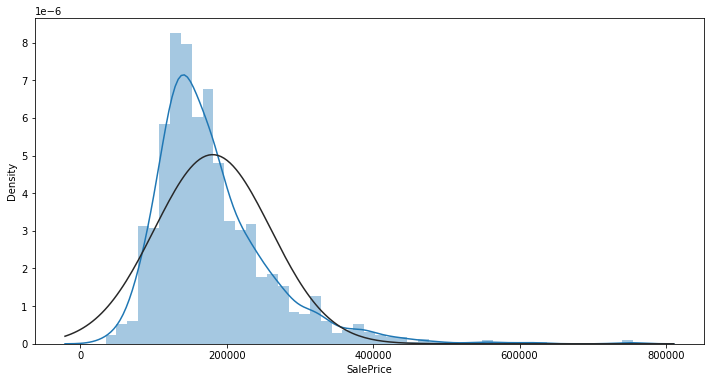

In [7]:
# 價格分布與常態分佈

(mu, sigma) = norm.fit(df_house_train['SalePrice'])

plt.figure(figsize = (12,6))
sns.distplot(df_house_train['SalePrice'], kde = True, hist=True, fit = norm)

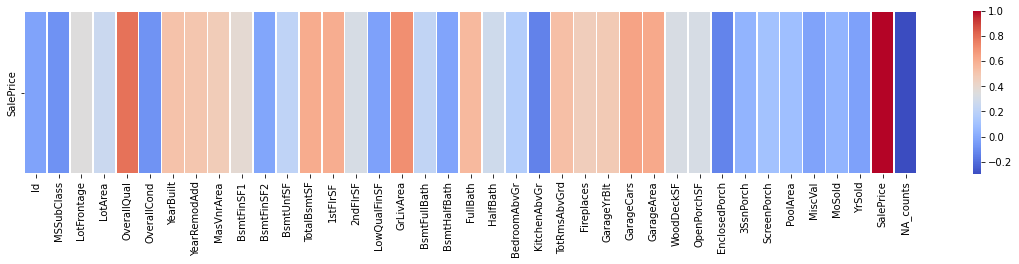

In [8]:
# 相關係數熱圖

f, ax = plt.subplots(figsize=(20, 3))
mat = df_house_train.corr('pearson')
sns.heatmap(mat.sort_values(by=['SalePrice'], ascending=False).head(1), cmap='coolwarm', linewidths=.5)

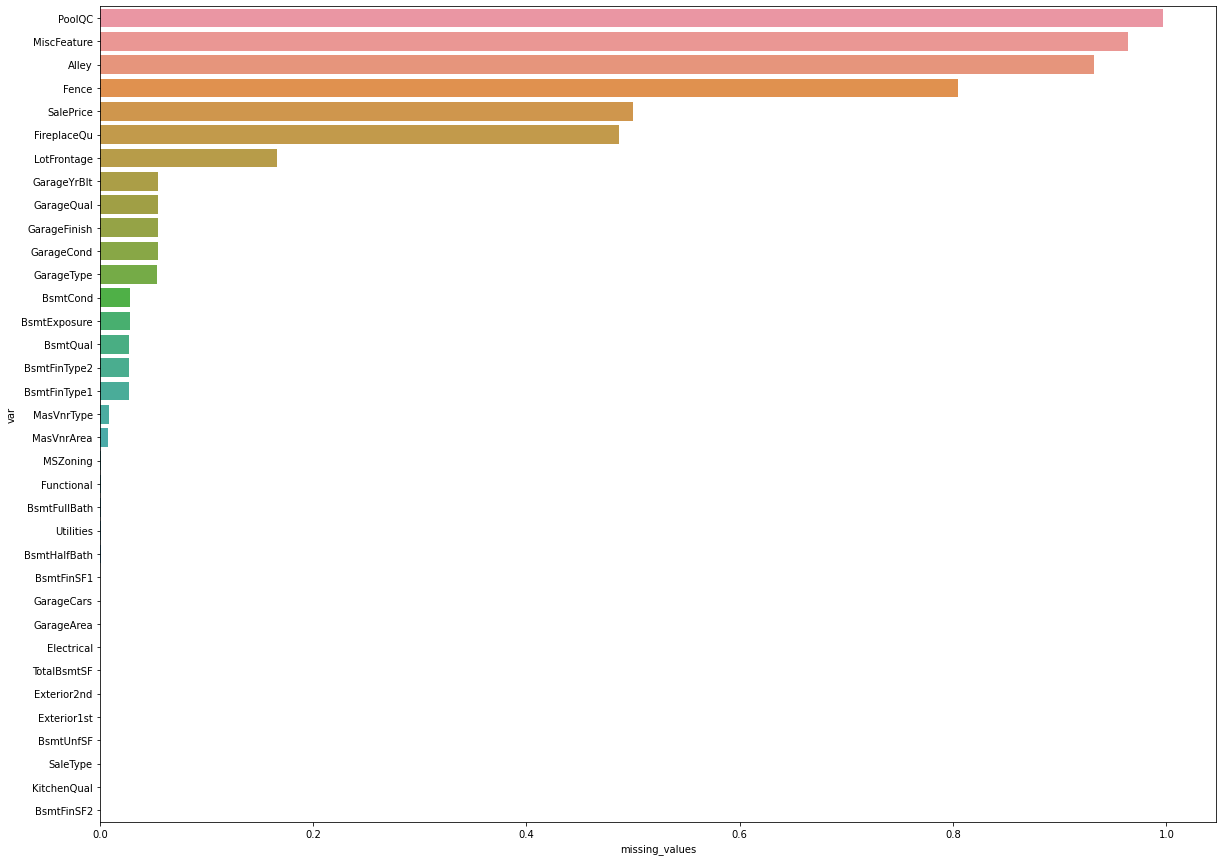

In [9]:
# 遺漏值情形

df_na = DataFrame(df_houses.isna().mean().sort_values(ascending=False)).reset_index()
df_na.columns = ['var', 'missing_values']
df_na = df_na[df_na['missing_values'] > 0]

fig,ax=plt.subplots(figsize=(20, 15))
sns.barplot(x='missing_values',y='var',data=df_na)

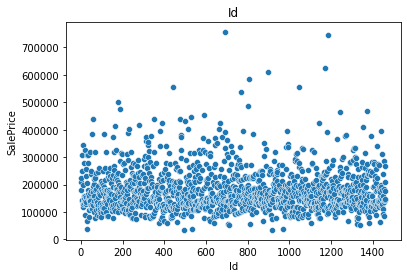

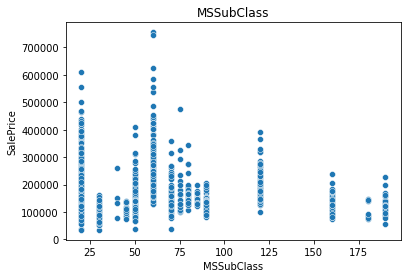

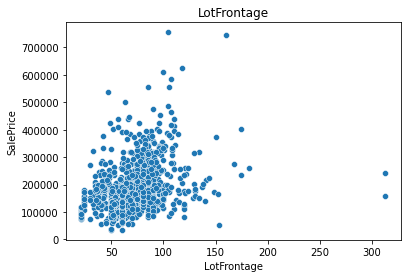

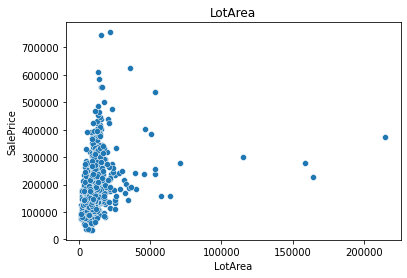

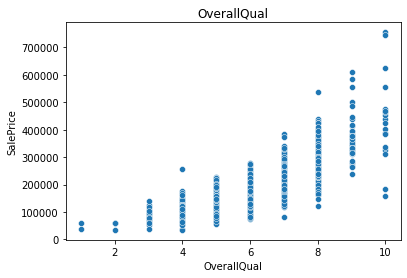

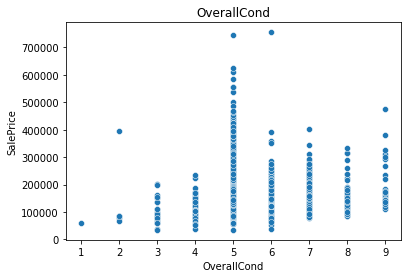

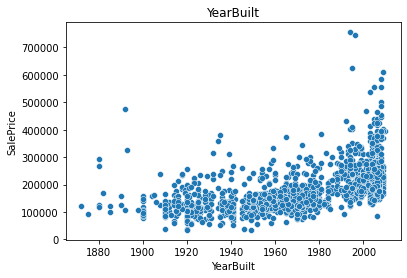

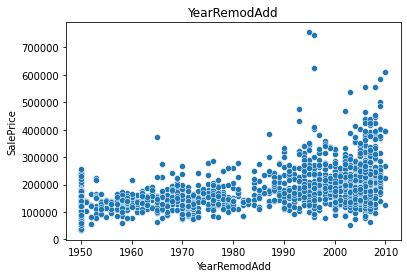

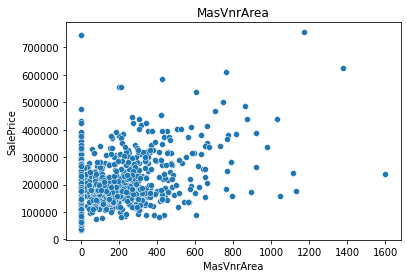

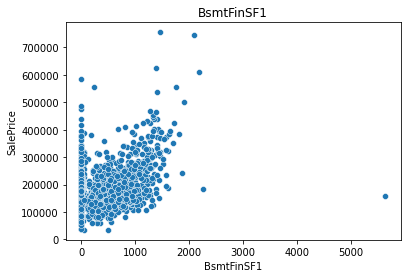

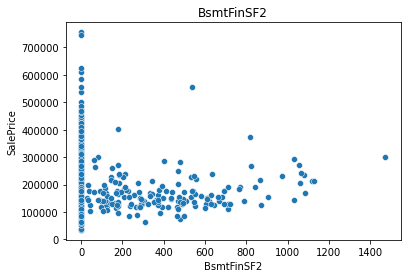

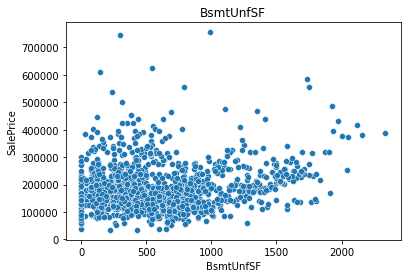

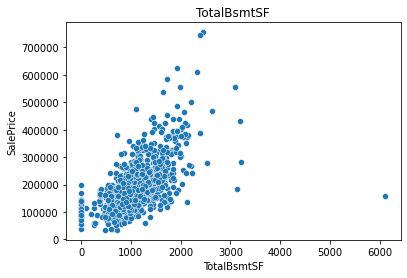

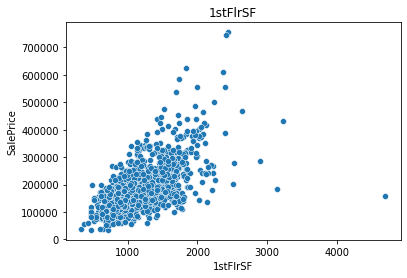

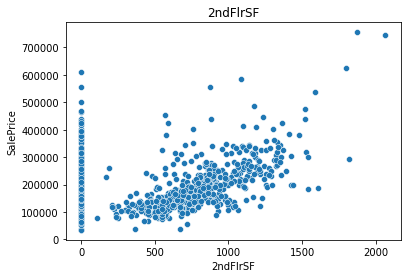

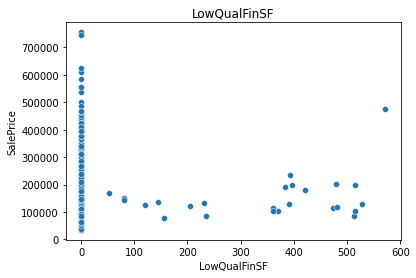

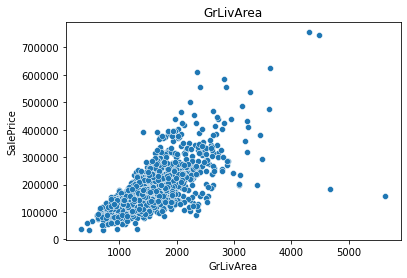

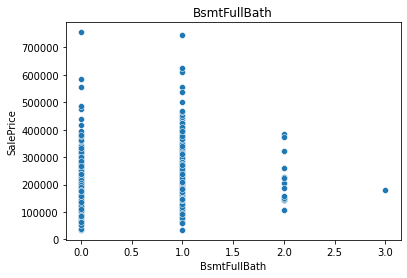

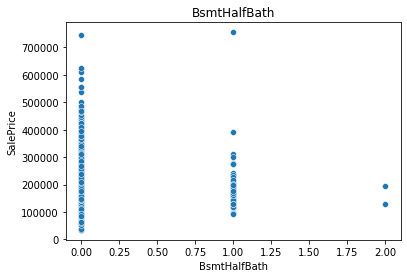

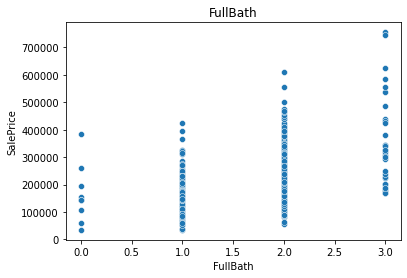

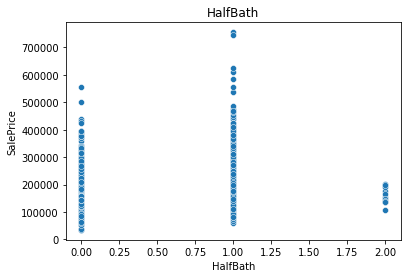

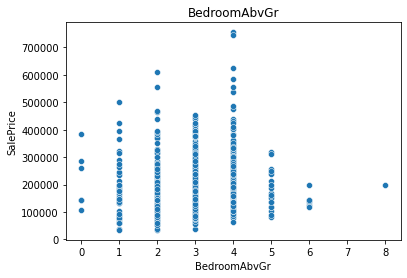

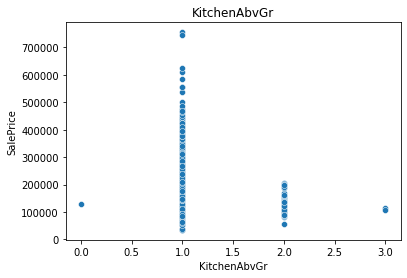

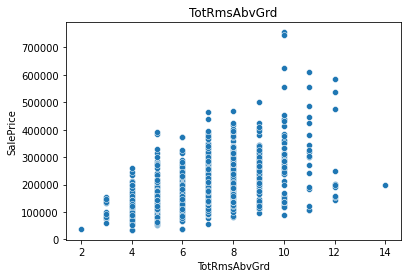

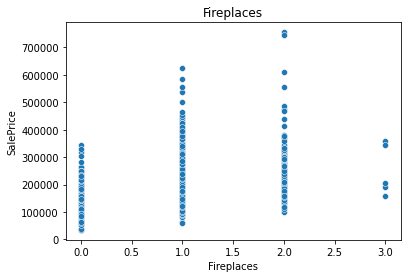

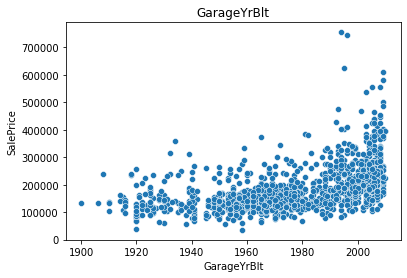

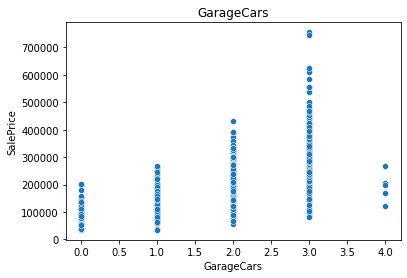

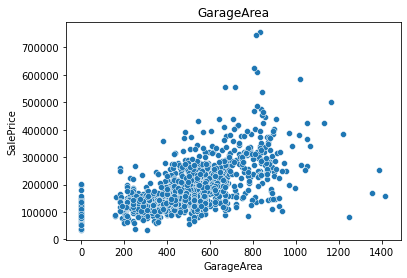

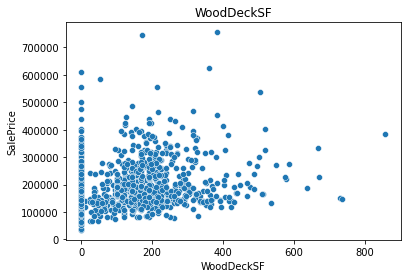

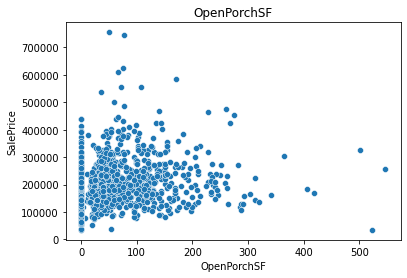

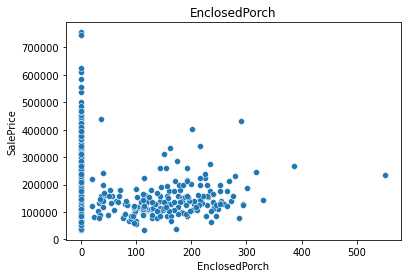

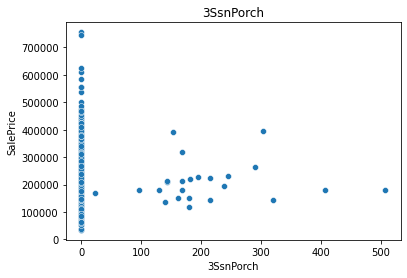

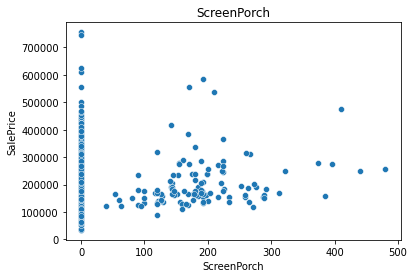

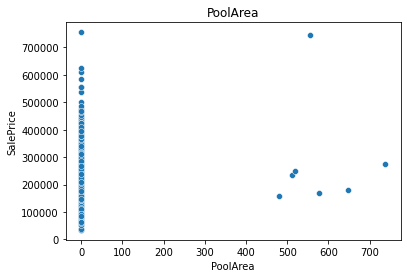

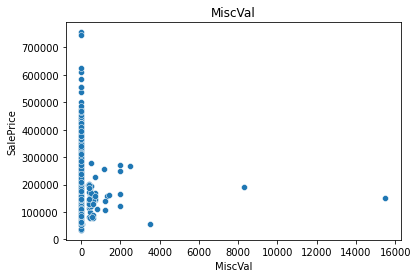

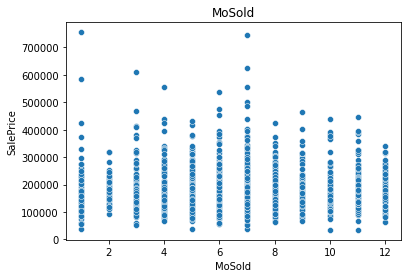

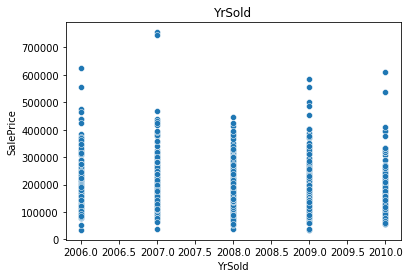

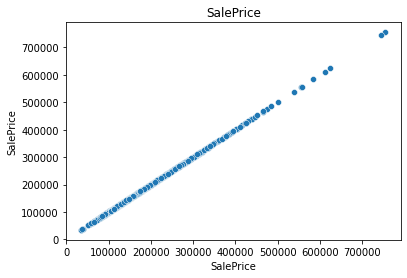

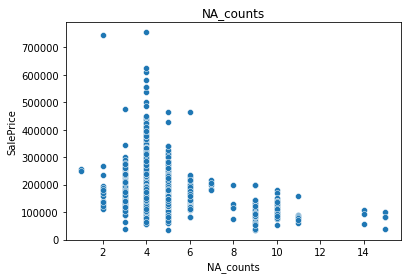

In [10]:
# 數值欄位分布與極端值

df_num_var = df_houses.select_dtypes(['int64','float64'])
for v in list(df_num_var.columns):
  sns.scatterplot(x= v, y= "SalePrice", data= df_house_train).set_title(v, fontsize=12,color='Black')
  plt.show()

### 處理遺漏與極端值
 * 極端值資料排除
 * 遺漏值處理

In [11]:
# 極端值資料排除(train)

var_outlier = ['LotFrontage', 'LotArea', 'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', 'MiscVal']
value_outlier = [300, 200000, 5000, 6000, 4000, 10000]

for i in range(len(var_outlier)):
    var = var_outlier[i]
    df_house_train = df_house_train[(df_house_train[var].isna()) | (df_house_train[var] < value_outlier[i])]
    print(i, df_house_train.shape)

df_houses = pd.concat([df_house_train, df_house_test])

0 (1458, 82)
1 (1457, 82)
2 (1457, 82)
3 (1457, 82)
4 (1457, 82)
5 (1456, 82)


In [12]:
# 遺漏值處理

## 移除遺漏值太多的欄位
df_houses = df_houses.drop(columns=['PoolQC', 'MiscFeature', 'Alley', 'Fence'], axis=1)

## 類別欄位: 訓練資料有缺值 3比以上補 none，否則補眾數
list_na_var = df_na['var'].tolist()[5:]
var_cat = df_houses.select_dtypes(['object']).columns.tolist()
var_num = df_houses.iloc[:, :-2].select_dtypes(['int64','float64']).columns.tolist()
for var in ['MSSubClass', 'MoSold']:
  var_cat.append(var)
  var_num.remove(var)

for i in var_cat:
  if df_house_train[i].isna().sum() >= 3:
    df_houses[i] = df_houses[i].fillna('none')
  else : 
    df_houses[i] = df_houses[i].fillna(df_house_train[i].mode()[0])

## 車庫年份補建造年份
df_houses['GarageYrBlt'] = df_houses['GarageYrBlt'].fillna(df_houses['YearBuilt'])

## 數值欄位: 訓練資料眾數為0補0、否則補中位數
for i in var_num:
  if df_house_train[i].mode()[0] == 0.0:
    df_houses[i] = df_houses[i].fillna(0)
  else:
    df_houses[i] = df_houses[i].fillna(df_house_train[i].median())

### 特徵工程
 * 計算屋齡等年份特徵
 * 把出售年份變成類別
 * One-Hot Encoding
 

In [13]:
# 計算屋齡等年份特徵

## 屋齡
df_houses['House_year'] = df_houses['YrSold'] - df_houses['YearBuilt']

## 整修
df_houses['Remod_year'] = df_houses['YrSold'] - df_houses['YearRemodAdd']

## 車庫
df_houses['Garage_year'] = df_houses['YrSold'] - df_houses['GarageYrBlt']

In [14]:
# 把出售年份變成類別

def to_year_group(x):  
  if x == 'none':
    return x
  elif x < 1920:
    group = 'Before_1920'
    return group
  elif (x >= 1920) & (x < 1940):
    group = '20-39'
    return group
  elif (x >= 1940) & (x < 1960):
    group = '40-59'
    return group
  elif (x >= 1960) & (x < 1980):
    group = '60-79'
    return group
  elif (x >= 1980) & (x < 1990):
    group = '80-89'
    return group
  elif (x >= 1990) & (x < 2000):
    group = '90-99'
    return group
  elif (x >= 2000) & (x < 2008):
    group = '00-07'
    return group
  elif (x >= 2008) & (x < 2013):
    group = '08-12'
    return group
  elif x >= 2013:
    group = 'After_2013'
    return group

df_houses['YrSold_group'] = df_houses['YrSold'].apply(lambda x: to_year_group(x))

In [15]:
# One-Hot Encoding

var_cat = df_houses.select_dtypes(['object']).columns.tolist()
df_houses = pd.get_dummies(df_houses, columns=var_cat , prefix=var_cat)

In [16]:
# 刪除多餘欄位、儲存處理後資料

df_houses = df_houses.drop(columns=['YrSold', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt'])
df_houses.to_csv('house_data.csv', encoding = 'utf-8-sig', index=0)

## 讀檔、標準化、切割訓練/測試/驗證集

In [17]:
# 標準化、切割訓練/測試/驗證集

df_houses = pd.read_csv('house_data.csv')

df_train_valid = df_houses[df_houses['SalePrice'] >= 0]
df_train, df_valid = train_test_split(df_train_valid, test_size=0.15, random_state=Random_seed)
df_test = df_houses[df_houses['SalePrice'].isna()].drop(columns=['SalePrice'], axis=1)

sc = StandardScaler()
sc.fit(df_train.drop(columns=['Id', 'SalePrice']))

X_train_all = sc.transform(df_train_valid.drop(columns=['Id', 'SalePrice'], axis=1)) 
y_train_all = np.log(df_train_valid['SalePrice'].values)
X_train = sc.transform(df_train.drop(columns=['Id', 'SalePrice'], axis=1)) 
y_train = np.log(df_train['SalePrice'].values)
X_valid = sc.transform(df_valid.drop(columns=['Id', 'SalePrice'], axis=1)) 
y_valid = np.log(df_valid['SalePrice'].values)
X_test = sc.transform(df_test.drop(columns=['Id'], axis=1))

In [18]:
#　各模型的最佳參數與 score

regs = {}
scores = {}

## 單一模型 

 * OLS
 * Ridge
 * Lasso
 * XGBoost  
 * CatBoost

### OLS

In [ ]:
# OLS

OLS_reg = LinearRegression(fit_intercept = True)
OLS_reg.fit(X_train, y_train)
regs["OLS"] = OLS_reg 

In [ ]:
# 預測及存檔

y_pred = OLS_reg.predict(X_valid)
rmse_valid = mean_squared_error(y_valid, y_pred, squared= False)
scores["OLS"] = rmse_valid
print('Valid RMSE:', rmse_valid)

OLS_reg.fit(X_train_all, y_train_all)

pred_OLS = OLS_reg.predict(X_test)
df_test['SalePrice'] = np.exp(pred_OLS)
df_test.loc[:, ['Id', 'SalePrice']].to_csv('./output/OLSReg.csv', index = 0)

Valid RMSE: 5911245423.046218


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()


### Ridge 

In [21]:
# Ridge 

param_grid = {'alpha': [1, 5, 10, 50, 100, 500, 1000],
        'fit_intercept': [True]
        }
Rid_grid = GridSearchCV(Ridge(), param_grid, scoring= "neg_mean_squared_error", cv= 3)
Rid_grid.fit(X_train, y_train)
Rid_reg = Ridge(**Rid_grid.best_params_)
Rid_reg.fit(X_train, y_train)

regs["Ridge"] = Rid_reg 
print("best estimator: {}".format(Rid_grid.best_params_))

best estimator: {'alpha': 500, 'fit_intercept': True}


In [22]:
# 預測及存檔

y_pred = Rid_reg.predict(X_valid)
rmse_valid = mean_squared_error(y_valid, y_pred, squared= False)
scores["Ridge"] = rmse_valid
print('Valid RMSE:', rmse_valid)

Rid_reg.fit(X_train_all, y_train_all)

pred_RidReg = Rid_reg.predict(X_test)
df_test['SalePrice'] = np.exp(pred_RidReg)
df_test.loc[:, ['Id', 'SalePrice']].to_csv('./output/RidReg.csv', index = 0)

Valid RMSE: 0.1340691909408029


### Lasso

In [23]:
# Lasso

param_grid = {'alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 1],
        'tol': [0.00001, 0.0001, 0.001, 0.01],
        'fit_intercept': [True],
        'random_state': [Random_seed]
        }
Las_grid = GridSearchCV(Lasso(), param_grid, scoring= "neg_mean_squared_error", cv= 3)
Las_grid.fit(X_train, y_train)
Las_reg = Lasso(**Las_grid.best_params_)
Las_reg.fit(X_train, y_train)


regs["Lasso"] = Las_reg 
print("best estimator: {}".format(Las_grid.best_params_))

best estimator: {'alpha': 0.005, 'fit_intercept': True, 'random_state': 57, 'tol': 0.01}


In [24]:
# 預測及存檔

y_pred = Las_reg.predict(X_valid)
rmse_valid = mean_squared_error(y_valid, y_pred, squared= False)
scores["Lasso"] = rmse_valid
print('Valid RMSE:', rmse_valid)

Las_reg.fit(X_train_all, y_train_all)

pred_LasReg = Las_reg.predict(X_test)
df_test['SalePrice'] = np.exp(pred_LasReg)
df_test.loc[:, ['Id', 'SalePrice']].to_csv('./output/LasReg.csv', index = 0)

Valid RMSE: 0.12718538981377514


### XGBoost

In [19]:
# XGBoost

'''
param_grid = {'objective': ['reg:squarederror'],
        'eval_metric': ['rmse'],
        'seed': [Random_seed],
        'n_estimators': [800, 1000, 1200],
        'max_depth': [3, 4, 5],
        'learning_rate': [0.001, 0.005, 0.01, 0.5]
        }
XGB_grid = GridSearchCV(XGBRegressor(), param_grid, scoring= "neg_mean_squared_error", cv= 3)
XGB_grid.fit(X_train, y_train)
XGB_reg = XGBRegressor(**XGB_grid.best_params_) 
print("best estimator: {}".format(XGB_grid.best_params_))
'''
best_params = {'eval_metric': 'rmse', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 1200, 'objective': 'reg:squarederror', 'seed': 57}
XGB_reg = XGBRegressor(**best_params)
XGB_reg.fit(X_train, y_train) 

regs["XGB"] = XGB_reg

In [20]:
# 預測及存檔

y_pred = XGB_reg.predict(X_valid)
rmse_valid = mean_squared_error(y_valid, y_pred, squared= False)
scores["XGB"] = rmse_valid
print('Valid RMSE:', rmse_valid)

XGB_reg.fit(X_train_all, y_train_all)

pred_XGBReg = XGB_reg.predict(X_test)
df_test['SalePrice'] = np.exp(pred_XGBReg)
df_test.loc[:, ['Id', 'SalePrice']].to_csv('./output/XGBReg.csv', index = 0)

Valid RMSE: 0.13217054464169053


### CatBoost

In [ ]:
# CatBoost

'''
param__grid = {'iterations': [100, 150, 200],
         'learning_rate': [0.01, 0.05, 0.1],
         'depth': [3, 4, 5, 6],
         'l2_leaf_reg': [0.1, 0.5, 1, 1.5]}
'params': {'depth': 3,
  'iterations': 200,
  'l2_leaf_reg': 0.1,
  'learning_rate': 0.05}}


CB_grid = CatBoostRegressor(random_state=Random_seed,
              loss_function='RMSE',
              eval_metric='RMSE')

CB_grid.grid_search(param__grid, X_train, y_train)
'''
CB_reg = CatBoostRegressor(random_state=Random_seed,
              loss_function='RMSE',
              eval_metric='RMSE',
              depth= 3,
              l2_leaf_reg= 0.1,
              learning_rate= 0.05)
CB_reg.fit(X_train, y_train)
regs["CB"] = CB_reg

In [26]:
# 預測及存檔

y_pred = CB_reg.predict(X_valid)
rmse_valid = mean_squared_error(y_valid, y_pred, squared= False)
scores["CB"] = rmse_valid
print('Valid RMSE:', rmse_valid)

CB_reg.fit(X_train_all, y_train_all, verbose = 0)

pred_CBReg = CB_reg.predict(X_test)
df_test['SalePrice'] = np.exp(pred_CBReg)
df_test.loc[:, ['Id', 'SalePrice']].to_csv('./output/CBReg.csv', index = 0)

Valid RMSE: 0.13085873476636564


## Ensemble model 

 * Voting
 * Stacking

### Voting
取平均值

In [ ]:
# Average

Avg_model = VotingRegressor([('Ridge', regs['Ridge']), 
                ('Lasso', regs['Lasso']), 
                ('XGB', regs['XGB']),
                ('CB', regs['CB'])]
                )
Avg_reg = Avg_model.fit(X_train, y_train)
regs["Avg"] = Avg_reg

In [ ]:
# 預測及存檔

y_pred = Avg_reg.predict(X_valid)
rmse_valid = mean_squared_error(y_valid, y_pred, squared= False)
scores["Avg"] = rmse_valid
print('Valid RMSE:', rmse_valid)

Avg_reg.fit(X_train_all, y_train_all)

pred_AvgReg = Avg_reg.predict(X_test)
df_test['SalePrice'] = np.exp(pred_AvgReg)
df_test.loc[:, ['Id', 'SalePrice']].to_csv('./output/AvgReg.csv', index = 0)

### Voting- Weights

依RMSE加權平均

In [ ]:
# 加權平均

a, b, c, d = scores["Ridge"], scores["Lasso"], scores["XGB"], scores["CB"]
x = (a*b*c*d) / (b*c*d + a*c*d + a*b*d + a*b*c)
weight = [x/a, x/b, x/c, x/d]

Vote_model = VotingRegressor([('Ridge', regs['Ridge']), 
                ('Lasso', regs['Lasso']), 
                ('XGB', regs['XGB']),
                ('CB', regs['CB'])],
                weights = weight,
                )
Vote_reg = Vote_model.fit(X_train, y_train)
regs["Vote"] = Vote_reg

In [ ]:
# 預測及存檔

y_pred = Vote_reg.predict(X_valid)
rmse_valid = mean_squared_error(y_valid, y_pred, squared= False)
scores["Vote"] = rmse_valid
print('Valid RMSE:', rmse_valid)

Vote_reg.fit(X_train_all, y_train_all)

pred_VoteReg = Vote_reg.predict(X_test)
df_test['SalePrice'] = np.exp(pred_VoteReg)
df_test.loc[:, ['Id', 'SalePrice']].to_csv('./output/VoteReg.csv', index = 0)

### Stacking

In [ ]:
# Stacking

model_list = [('Ridge', regs['Ridge']), ('Lasso', regs['Lasso']), ('XGB', regs['XGB'],), ('CB', regs['CB'])]

param_grid = {'estimators': [model_list], 
        'final_estimator': [LinearRegression(),
                   Ridge()]}

Stacking_grid = GridSearchCV(StackingRegressor(model_list), param_grid, scoring= "neg_mean_squared_error")
Stacking_grid.fit(X_train, y_train)
Stacking_model = StackingRegressor(**Stacking_grid.best_params_)
Stack_reg = Stacking_model.fit(X_train, y_train)
regs["Stack"] = Stack_reg
print("best estimator: {}".format(Stacking_grid.best_params_))

In [ ]:
# 預測及存檔

y_pred = Stack_reg.predict(X_valid)
rmse_valid = mean_squared_error(y_valid, y_pred, squared= False)
scores["Stack"] = rmse_valid
print('Valid RMSE:', rmse_valid)

Stack_reg.fit(X_train_all, y_train_all)

pred_StackReg = Stack_reg.predict(X_test)
df_test['SalePrice'] = np.exp(pred_StackReg)
df_test.loc[:, ['Id', 'SalePrice']].to_csv('./output/StackReg.csv', index = 0)

## Pytorch

### Hyper-parameters

In [ ]:
# Hyper-parameters

learning_rate = 0.0001
momentum = 0.95
weight_decay = 0.00001
batch_size = 150
n_jobs = 4
n_epochs = 2000                
patience = 400               
save_path = 'model/NN.pth' 
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Data
 * Dataset
 * DataLoader


In [ ]:
# Dataset 

class DataSet(Dataset):
  def __init__(self, X, Y):

    self.X = X
    self.Y = Y
    self.length = len(X)

  def __len__(self):

    return self.length

  def __getitem__(self, index):

    x = self.X[index]
    y = self.Y[index]

    return x, y

In [ ]:
# DataLoader

trainset = DataSet(X_train, y_train)
validset = DataSet(X_valid, y_valid)
trainallset = DataSet(X_train_all, y_train_all)

trainloader = DataLoader(trainset, batch_size = batch_size, num_workers = n_jobs, shuffle = True)
validloader = DataLoader(validset, batch_size = batch_size, num_workers = n_jobs, shuffle = True)
trainallloader = DataLoader(trainallset, batch_size = batch_size, num_workers = n_jobs, shuffle = True)

### Neural Network Model

 * Model
 * Train


In [ ]:
# Model

class NeuralNet(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNet, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(input_dim, 1200),
            nn.ReLU(),
            nn.Linear(1200, 48),
            nn.Dropout(p=0.3),
            nn.Linear(48, 1)
        )

    def forward(self, x):
        return self.net(x).squeeze()

In [ ]:
# Train

def train(trainloader, model, criterion, device) :

  model.train()    
  for data in trainloader:

      x, y = data[0].float().to(device), data[1].float().to(device) 

      optimizer.zero_grad()
      output = model(x)
      
      loss = criterion(output, y)
      loss.backward()
      optimizer.step()
  
  return loss

### Train & Predict

In [ ]:
# Train

model = NeuralNet(X_train.shape[1]).to(device)
criterion = nn.MSELoss()

#optimizer = torch.optim.AdamW(model.parameters(), lr = learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
#optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = momentum, weight_decay = weight_decay)

best_loss = 100000
best_epochs = n_epochs
early_stop = False
early_stop_cnt = 0
since = time.time()
for epoch in range(n_epochs):
    
  train_loss = train(trainloader, model, criterion, device)
  
  model.eval()
  with torch.no_grad():
    y = torch.tensor(X_valid).float().to(device)
    out = model(y).squeeze().detach().cpu().numpy()
    valid_loss = mean_squared_error(y_valid, out, squared= False)
  
  print('Epoch {}/{}'.format(epoch+ 1, n_epochs))
  print('Valid Loss: {:.8f}'.format(valid_loss))
    
  if valid_loss < best_loss:
    best_loss = valid_loss
    best_epochs = epoch           
    torch.save(model.state_dict(), save_path)

    print('Saving The Model') 
    early_stop_cnt = 0
  else:
    print("Counter {} of {}".format(early_stop_cnt+ 1, patience))
    early_stop_cnt += 1
     
  print('-' * 10)

  if early_stop_cnt >= patience:
    print("Early stop!")
    early_stop = True

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best valid Loss: {:.8f}, epoch {}'.format(best_loss, best_epochs))
    break

if early_stop == False:

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  print('Best valid Loss: {:.8f}'.format(best_loss))

In [ ]:
# Valid rmse

model = NeuralNet(X_train.shape[1])
model.load_state_dict(torch.load("model/NN.pth"))

model.eval()
with torch.no_grad():
  pred_valid = model(torch.tensor(X_valid).float()).squeeze().detach().numpy()

rmse_valid = mean_squared_error(y_valid, pred_valid, squared= False)
print('Valid_RMSE :', rmse_valid)

In [ ]:
# Train with all data

model = NeuralNet(X_train.shape[1]).to(device)
model.load_state_dict(torch.load("model/NN.pth"))

criterion = nn.MSELoss()
#optimizer = torch.optim.AdamW(model.parameters(), lr = learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
#optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = momentum)#, weight_decay = weight_decay)

since = time.time()
for epoch in range(best_epochs):
  train_loss = train(trainloader, model, criterion, device) 

torch.save(model.state_dict(), "model/NN_all.pth")
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

In [ ]:
# Predict

model = NeuralNet(X_train.shape[1])
#model.load_state_dict(torch.load("model/NN.pth"))
model.load_state_dict(torch.load("model/NN_all.pth"))

model.eval()
with torch.no_grad():
  pred_torch = model(torch.tensor(X_test).float()).squeeze().detach().numpy()

df_test['SalePrice'] = np.exp(pred_torch)
#df_test.loc[:, ['Id', 'SalePrice']].to_csv('./output/Torch_AdamW.csv', index = 0)
df_test.loc[:, ['Id', 'SalePrice']].to_csv('./output/Torch_Adam.csv', index = 0)
#df_test.loc[:, ['Id', 'SalePrice']].to_csv('./output/Torch_SGD.csv', index = 0)